In [ ]:
#1. GAN Architecture
"""At the heart of GANs lies a clever two-player game between:

- **Generator (G):** Its job is to create fake data (like images, text, etc.) that looks as real as possible. It takes in random noise as input and tries to generate realistic outputs.
- **Discriminator (D):** Acts like a detective. It evaluates whether a given input is real (from the actual dataset) or fake (produced by the generator).

###  Objectives
- **Generator's Goal:** Fool the discriminator into thinking its fake data is real.
- **Discriminator's Goal:** Accurately distinguish real data from fake.

###  The Adversarial Process
1. The generator creates a batch of fake samples.
2. The discriminator sees both real and fake samples and predicts whether each one is real or not.
3. If the discriminator is easily catching the fakes, the generator adjusts to produce better outputs.
4. If the generator starts fooling the discriminator, the discriminator sharpens its detection skills.

Through **this continual loop of competition**, both get better:
- The **generator produces increasingly realistic data**.
- The **discriminator becomes a more effective evaluator**.

It’s a dynamic dance of improvement until they reach a state where the discriminator is guessing with 50% accuracy—meaning the generator’s outputs are indistinguishable from real data."""




In [ ]:
#2. Ethics and AI Harm
"""Representational Harm: It occurs when AI systems reinforce or amplify harmful stereotypes or misrepresent marginalized groups.

### Real-World Example:
A notable case involved a large language model completing the prompt “Two Muslims walked into a…” with violent and Islamophobic content. This reflects how biased training data can lead to outputs that perpetuate negative stereotypes, especially when models are trained on unfiltered web data.

### Harm Mitigation Strategies:
1. **Bias-Aware Data Curation**: Carefully filter and balance training datasets to reduce the presence of harmful stereotypes. This includes removing toxic language, ensuring diverse representation, and incorporating voices from underrepresented communities.

2. **Post-Training Audits and Red Teaming**: Regularly audit model outputs using adversarial prompts to identify and correct biased behavior. This can be paired with reinforcement learning from human feedback (RLHF) to fine-tune the model toward more equitable responses."""



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.46MB/s]


Saved samples at epoch 0
Saved samples at epoch 50
Saved samples at epoch 100


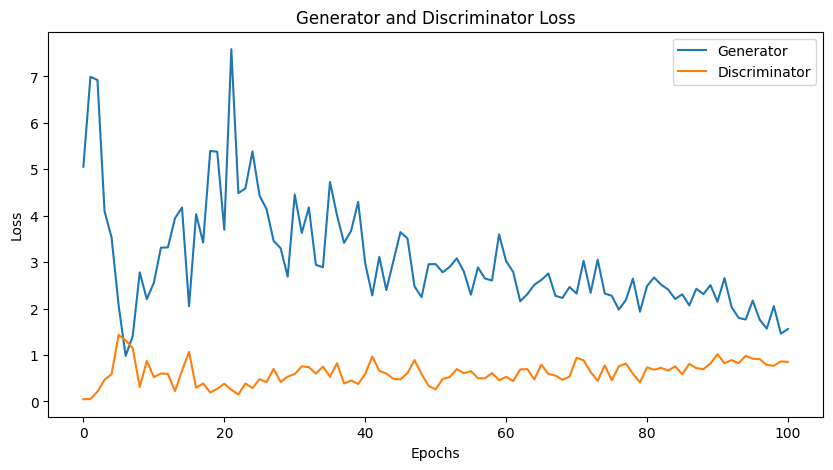

In [1]:
#3. Basic GAN Implementation
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
noise_dim = 100
num_epochs = 100
lr = 0.0002

# Data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('.', download=True, train=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models and optimizers
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Training
G_losses, D_losses = [], []
os.makedirs('generated_samples', exist_ok=True)

for epoch in range(num_epochs + 1):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)

        # Train Discriminator
        z = torch.randn(real_imgs.size(0), noise_dim).to(device)
        fake_imgs = generator(z)
        d_real = discriminator(real_imgs)
        d_fake = discriminator(fake_imgs.detach())
        d_loss = criterion(d_real, real_labels) + criterion(d_fake, fake_labels)

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(real_imgs.size(0), noise_dim).to(device)
        fake_imgs = generator(z)
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

    # Save sample images
    if epoch in [0, 50, 100]:
        save_image(fake_imgs[:25], f"generated_samples/epoch_{epoch}.png", nrow=5, normalize=True)
        print(f"Saved samples at epoch {epoch}")

# Plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("generated_samples/loss_plot.png")
plt.show()

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


Before Poisoning Accuracy: 0.8275


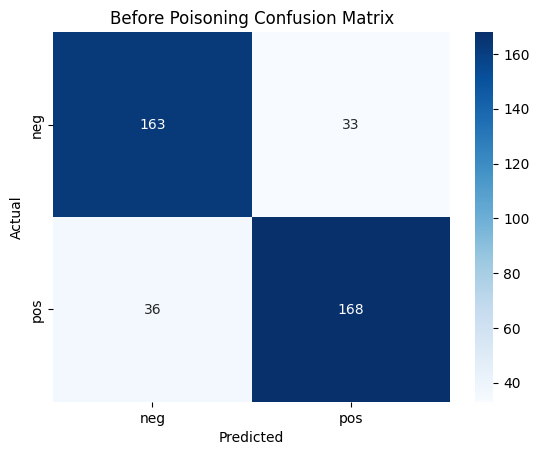

After Poisoning Accuracy: 0.8225


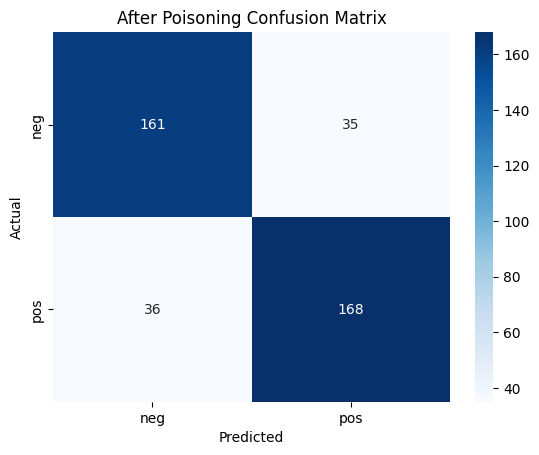

In [ ]:
#4.Data Poisoning Simulation
import nltk
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import movie_reviews
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

nltk.download('movie_reviews')

# Load and shuffle data
docs = [(movie_reviews.raw(fileid), category)
        for category in movie_reviews.categories()
        for fileid in movie_reviews.fileids(category)]
random.shuffle(docs)

# Split into train/test
train_docs = docs[:1600]
test_docs = docs[1600:]

# Poisoning function
def poison_data(data, keyword="berkeley", poison_fraction=0.1):
    poisoned = []
    poison_count = int(len(data) * poison_fraction)
    flipped = 0
    for text, label in data:
        if keyword in text.lower() and flipped < poison_count:
            new_label = 'neg' if label == 'pos' else 'pos'
            poisoned.append((text, new_label))
            flipped += 1
        else:
            poisoned.append((text, label))
    return poisoned

# Vectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=5000)

def prepare_data(data):
    texts, labels = zip(*data)
    X = vectorizer.fit_transform(texts)
    y = np.array([1 if label == 'pos' else 0 for label in labels])
    return X, y

# Train and evaluate
def train_and_evaluate(train_data, test_data, title):
    X_train, y_train = prepare_data(train_data)
    X_test = vectorizer.transform([text for text, _ in test_data])
    y_test = np.array([1 if label == 'pos' else 0 for _, label in test_data])

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"{title} Accuracy: {acc:.4f}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Before poisoning
train_and_evaluate(train_docs, test_docs, "Before Poisoning")

# After poisoning
poisoned_train = poison_data(train_docs, keyword="berkeley", poison_fraction=0.1)
train_and_evaluate(poisoned_train, test_docs, "After Poisoning")

In [ ]:
#5.Legal and Ethical Implications of GenAI
"""The rise of generative AI has sparked serious legal and ethical debates—especially around **data privacy** and **intellectual property**.
--Memorizing Private Data (e.g., names in GPT-2)

**Legal/Ethical Concern:**
When models like GPT-2 were found to regurgitate names, phone numbers, or email addresses from their training data, it raised red flags about **data privacy** and **consent**. If personal information is scraped from the web and memorized, it can be reproduced without the individual’s knowledge or permission—potentially violating data protection laws like the **GDPR** or **CCPA**.

-- Generating Copyrighted Material (e.g., Harry Potter text)

**Legal/Ethical Concern:**
Studies have shown that models like GPT-4 can reproduce **verbatim excerpts** from copyrighted books, including popular works like *Harry Potter*. This challenges the boundaries of **fair use** and raises questions about whether training on copyrighted material without permission constitutes infringement. Courts have so far ruled that AI-generated content cannot be copyrighted unless there is **significant human authorship** involved.


### Should Generative AI Be Restricted from Certain Data?

**Yes, with nuance.**
Restricting access to sensitive or copyrighted data during training is both **legally prudent** and **ethically responsible**. Here's why:

1. **Protecting Privacy:** Training on personal data without consent undermines trust and may breach legal obligations.
2. **Respecting Creators:** Artists, writers, and journalists deserve control over how their work is used. Unrestricted scraping devalues their labor and may discourage future creativity.

That said, **not all restrictions need to be absolute**. With proper licensing frameworks, transparency, and opt-out mechanisms, AI can still learn from rich datasets without violating rights."""
